In [66]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

In [2]:
features = pd.read_csv('features.csv', header=None, encoding='latin')
features.columns= ['id', 'gen', 'sp', 'ssp', 'en', 'cnt', 'loc', 'type', 'q', 'length', 'bird-seen']
features.head()

,id,gen,sp,ssp,en,cnt,loc,type,q,length,bird-seen
0,418340,Branta,canadensis,NaN,Canada Goose,United States,"Au Sable SF - Big Creek Rd, Michigan",song,A,0:14,yes
1,417786,Branta,canadensis,NaN,Canada Goose,United States,"Drayton Plains Nature Center, Oakland County, ...","Hissing, peeping",A,1:04,unknown
2,409020,Branta,canadensis,NaN,Canada Goose,United States,"Watkins Lake State Park, Jackson County, Michigan","call, flight call",A,0:49,yes
3,388771,Branta,canadensis,NaN,Canada Goose,United States,"Cranberry Lake Park, Oakland County, Michigan",call,B,0:15,no
4,11837,Branta,canadensis,maxima,Canada Goose,United States,"Michigan, Pte. Mouillee SGA",call,B,0:19,unknown


In [3]:
# These are the top species we selected for our analysis
selected_species = ["Kirtland's Warbler",
                    'Common Yellowthroat',
                    'Red-winged Blackbird',
                    'Grey Catbird',
                    'American Redstart']
# We only need the id and the labels for our CNN.
dataset = features[features.en.isin(selected_species)][['id', 'en']]
# Now we need to change our labels into integers as torch does not support string format for labels.
labels = {"Kirtland's Warbler": 0, 'Common Yellowthroat': 1, 'Red-winged Blackbird': 2, 'Grey Catbird': 3,
          'American Redstart': 4}
dataset['label'] = dataset.apply(lambda row: labels[row.en], axis=1)
dataset.drop('en', axis=1, inplace=True)

# Taking 20% of the dataset off for testing
train, test = train_test_split(dataset, test_size=0.2)

print(train.label.value_counts())
print('')
print(test.label.value_counts())

2    37
4    30
1    29
3    27
0    17
Name: label, dtype: int64

0    11
4     7
1     7
3     6
2     5
Name: label, dtype: int64


In [28]:
def load_images(dataset, dimensions='2D', gray=True):
    img_df = []
    for img_name in tqdm(dataset['id']):
        # defining the image path
        image_path = 'images/mel_spectrograms_8sec/' + str(img_name) + '.jpg'
        # reading the image
        img = imread(image_path, as_gray=gray)
        # normalizing the pixel values
        img /= 255.0
        # converting the type of pixel to float 32
        img = img.astype('float32')
        # appending the image into the list
        if dimensions == '1D':
            img_df.append(img.flatten())
        else:
            img_df.append(img)
    
    # converting the list to numpy array
    return np.array(img_df)

def visualizing_images(dataset):
    # Only works for 2D arrays
    i = 0
    plt.figure(figsize=(10,10))
    plt.subplot(221), plt.imshow(dataset[i], cmap='gray')
    plt.subplot(222), plt.imshow(dataset[i+25], cmap='gray')
    plt.subplot(223), plt.imshow(dataset[i+50], cmap='gray')
    plt.subplot(224), plt.imshow(dataset[i+75], cmap='gray')

# Random Forest 

In [26]:
X_train, y_train = load_images(train, dimensions='1D', gray=True), train['label'].values
X_train.shape

100%|███████████████████████████████████████████████████████████████████████████████| 140/140 [00:01<00:00, 115.42it/s]


(140, 435456)

In [27]:
X_test, y_test = load_images(test, dimensions='1D', gray=True), test['label'].values
X_test.shape

100%|█████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 117.65it/s]


(36, 435456)

In [14]:
train_x.shape

(140, 435456)

In [42]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [43]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4166666666666667


In [47]:
from sklearn.metrics import f1_score
print("F1 score: ", f1_score(y_test, y_pred, average='micro'))
print("F1 score: ", f1_score(y_test, y_pred, average='weighted'))

F1 score:  0.4166666666666667
F1 score:  0.4138077565709145


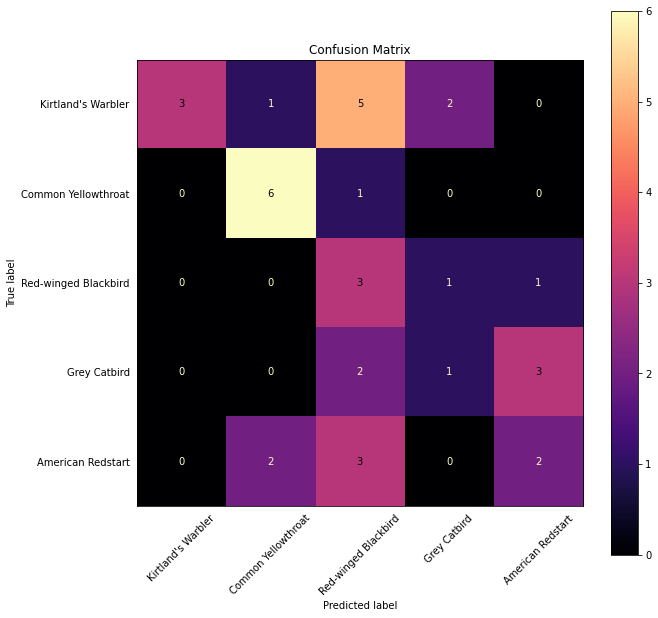

In [103]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=selected_species)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Predicted labels')
ax.tick_params(axis = "both", which = "both", bottom = False, left=False)
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
disp.plot(ax=ax, xticks_rotation=45, cmap='magma')